In [16]:
import pathlib
import pandas as pd
import numpy as np
import os
import math
from more_itertools import unique_everseen
from scipy import stats
import statistics
from scipy.stats.stats import pearsonr
import statsmodels.formula.api as smf
import seaborn
import matplotlib.pyplot as plt
import random
import warnings; warnings.simplefilter('ignore')

In [2]:
root = pathlib.Path(os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') + "/SearchTool_Matches/")
markovlisttemp = [root / 'MARKOV/' / x for x in os.listdir(root / 'MARKOV/')]
ospanlisttemp = [root / 'OSPAN/' / x for x in os.listdir(root / 'OSPAN/')]
cortdf = pd.read_excel(open(root / 'Cortisol/Cortisol_Analysis_S3.xlsx',"rb"), index_col=False)
cortdf['Log Mean (µg/dL)'] = [math.log(y,10) for y in cortdf['Mean (µg/dL)']]
cortsubslist = list(unique_everseen(cortdf['Record ID'].astype(int)))
cortsubslist.sort()
markovlist = []
ospanlist = []
newcortsubslist = []
moodlist = []
orderlist = []
for i, x in enumerate(cortsubslist):
    hasMARKOV = False
    hasOSPAN = False
    for i, y in enumerate(markovlisttemp):
        if "%04d" % x in y.name:
            markovlist.append(y)
            hasMARKOV = True
            for j, z in enumerate(ospanlisttemp):
                if "%04d" % x in z.name:
                    ospanlist.append(z)
                    hasOSPAN = True
                    break
        if hasMARKOV == True and hasOSPAN == True:
            newcortsubslist.append(x)
            moodlist.append(cortdf['Mood Condition'][i])
            orderlist.append(cortdf['Assessment Order'][i])
            break
scoreslist = []
for x in ospanlist:
    scoreslist.append(pd.read_csv(x)['runningcorrect'].iloc[-1])

In [3]:
for i, x in enumerate(markovlist):
    name = os.path.basename(x)[9:13]
    score = scoreslist[i]
    if i == 0:
        df = pd.read_csv(x, delimiter=',', index_col=False)
        df = df.iloc[9:]
        df.insert(0, 'WMGroup', score)
        df.insert(0, 'SubjectID', name)
    elif i > 0:
        tempdf = pd.read_csv(x, delimiter=',', index_col=False)
        tempdf = tempdf.iloc[9:]
        tempdf.insert(0, 'WMGroup', score)
        tempdf.insert(0, 'SubjectID', name)
        df = df.append(tempdf, ignore_index=True)

level1list = []
level2list = []
        
df = df.drop(df[df.choice1 == 0].index)
df = df.drop(df[df.choice2 == 0].index)

table = pd.DataFrame(
        {'subjID': df.SubjectID,
         'reward': df.money
        })

for x in list(df.choice1):
    level1list.append('stimulus %s' % x)
    
table['level1_choice'] = level1list
    
this = 10*df.choice1 + df.choice2

for x in this:
    if x == 11:
        level2list.append('stimulus 3')
    if x == 12:
        level2list.append('stimulus 4')
    if x == 21:
        level2list.append('stimulus 5')
    if x == 22:
        level2list.append('stimulus 6')
            
table['level2_choice'] = level2list

df.to_csv("markov_dataset.csv", sep=',', index=False)
table.to_csv("markov_dataset.txt", sep='\t', index=False)

In [4]:
df = pd.read_csv('markov_dataset.csv', delimiter=',', index_col=False)
modelfreebetaslist = []; modelbasedbetaslist = []
modelfreebetascortlist = []; modelbasedbetascortlist = []
check = []
modeldellist = []
for i, x in enumerate(newcortsubslist):
    model = smf.logit('stay ~ prevmoney*common', df[pd.to_numeric(df.SubjectID) == x]).fit()
    if model.summary()[1]==0 and model.mle_retvals['converged']==True:
    #if model.mle_retvals['converged']==True and model.mle_retvals['warnflag']==0: 
        modelfreebetaslist.append(model.params[1])
        modelbasedbetaslist.append(model.params[3])
        if model.params[3] < -10:
            print(model.summary())
            print(model.mle_retvals)
    else:
        modeldellist.append(i)
        print(i)
    check.append([x, model.summary()])
    
newnewcortsubslist = newcortsubslist

loop = 0
for x in modeldellist:
    newnewcortsubslist.pop(x-loop)
    scoreslist.pop(x-loop)
    moodlist.pop(x-loop)
    orderlist.pop(x-loop)
    loop += 1
       
cortsampleslist = []
sampdiflist = [4,5]
for x in list(newnewcortsubslist):
    subrow = cortdf[cortdf['Record ID'] == x].reset_index()
    if len(subrow.index) > 0:
        temp = []
        for x in range(1,12):
            try:
                temp.append(subrow[subrow['General Time'] == x].reset_index()['Log Mean (µg/dL)'][0])
            except:
                temp.append(None)
        cortsampleslist.append(temp)
dellist = []
for i, x in enumerate(cortsampleslist):
    #if (isinstance(x[sampdiflist[0]-1], np.float64) == False or isinstance(x[sampdiflist[1]-1], np.float64) == False):
    if (isinstance(x[sampdiflist[0]-1], np.float64) == False or isinstance(x[sampdiflist[1]-1], np.float64) == False) or (isinstance(x[sampdiflist[0]+2], np.float64) == False or isinstance(x[sampdiflist[1]+2], np.float64) == False):
        dellist.append(i)
loop = 0
for x in dellist:
    cortsampleslist.pop(x-loop)
    modelfreebetaslist.pop(x-loop)
    modelbasedbetaslist.pop(x-loop)
    scoreslist.pop(x-loop)
    moodlist.pop(x-loop)
    orderlist.pop(x-loop)
    loop +=1
# diftrierlist = [i-j for i,j in zip([x[sampdiflist[1]-1] for x in cortsampleslist],[x[sampdiflist[0]-1] for x in cortsampleslist])]
# diftrierlistz = stats.mstats.zscore(diftrierlist)
diftrierlist=[]
for i, x in enumerate(cortsampleslist):
    if orderlist[i] == '1A-1B-2A-2B':
        #diftrierlist.append(((x[sampdiflist[1]-1]+x[sampdiflist[0]-1])/2)/((x[0]+x[1])/2))
        diftrierlist.append((((x[sampdiflist[0]-1])/((x[0]+x[1])/2))*100)-100)
    else:
        #diftrierlist.append(((x[sampdiflist[1]+2]+x[sampdiflist[0]+2])/2)/((x[0]+x[1])/2))
        diftrierlist.append((((x[sampdiflist[0]+2])/((x[0]+x[1])/2))*100)-100)

Optimization terminated successfully.
         Current function value: 0.415793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.262744
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.456638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550457
         Iterations 6
         Current function value: 0.076361
         Iterations: 35
7
Optimization terminated successfully.
         Current function value: 0.485444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574836
         Iterations 6
Optimization t

r = 0.058060119450950264, p = 0.6512752720780464


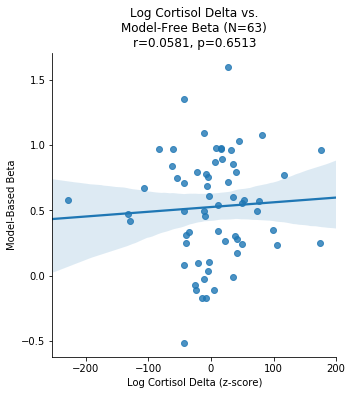

In [6]:
#Edit These
SAVE = False
var1 = diftrierlist
var2 = modelfreebetaslist
var1label = "Log Cortisol Delta (z-score)"
var2label = "Model-Based Beta"
title = "Log Cortisol Delta vs.\nModel-Free Beta (N=%s)" % len(var1)
savename = "Analyses\\Markov\\MSCEITTotal-ModelBased.pdf"

#--------------------------------------------
table = pd.DataFrame(
    {var1label: var1,
    var2label: var2
    })
for x in table.columns:
    table = table[np.isfinite(table[x])]

lm = seaborn.lmplot(x=var1label, y=var2label, palette=('r'), data=table, legend_out=False)
ax = plt.gca()
ax.set_title("%s\nr=%.4f, p=%.4f" % (title,pearsonr(table[var1label],table[var2label])[0],pearsonr(table[var1label],table[var2label])[1]))
print("r = %s, p = %s" % pearsonr(table[var1label],table[var2label]))
if SAVE == True:
    lm.savefig(root+savename, bbox_inches='tight')

High Group: r = 0.01698610463036304, p = 0.9216728205722993
Low Group: r = -0.4241123627884646, p = 0.02747280569734539
Mean of Grouping Variable: 91.0000
First Tertile of Grouping Variable: 90.6667
Second Tertile of Grouping Variable: 95.0000


<Figure size 432x288 with 0 Axes>

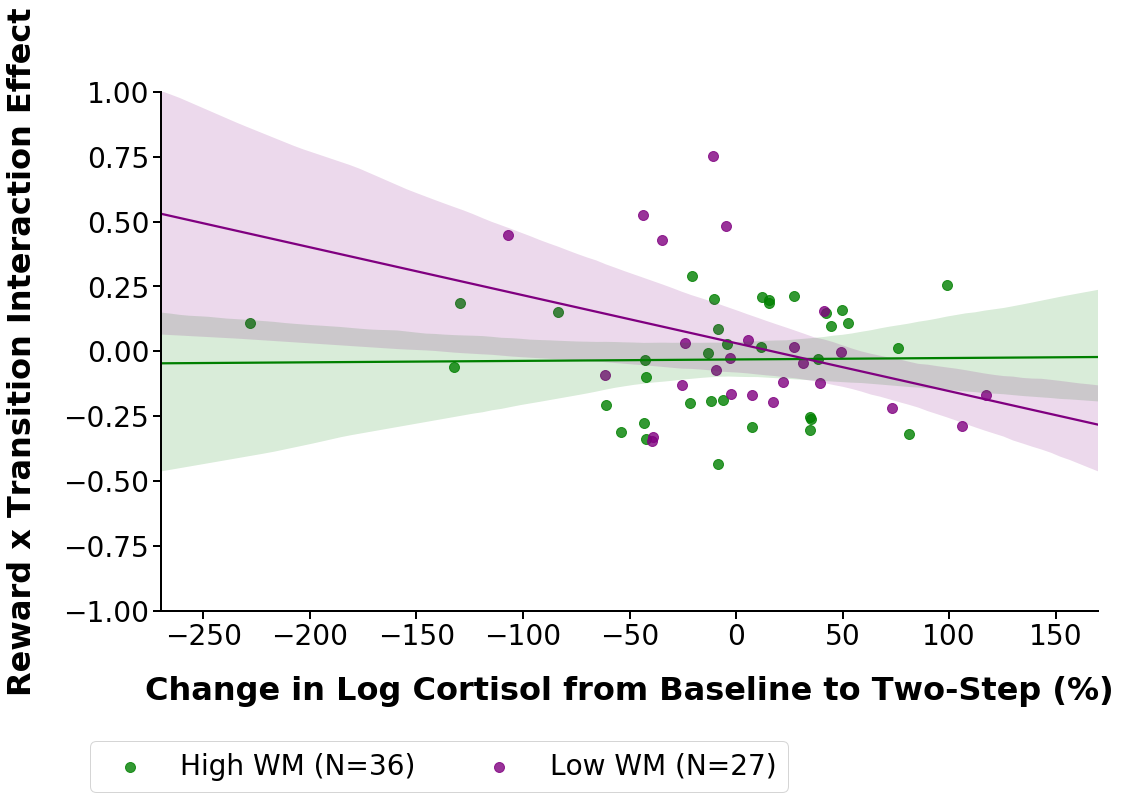

In [34]:
#Edit These
SAVE = False
var1 = diftrierlist
var2 = modelbasedbetaslist
groupvar = scoreslist
MEANSPLIT = True
var1label = "Change in Log Cortisol from Baseline to Two-Step (%)"
var2label = "Reward x Transition Interaction Effect"
highgrouplabel = "High WM"
lowgrouplabel = "Low WM"
midgrouplabel = "Average WM"
title = "Reward x Transition Interaction Effect vs\nPre-Post TSST Difference in Cortisol"
titlefont = {'weight':'bold','size':18,}
xlabelfont = {'weight':'bold','size':32,}
ylabelfont = {'weight':'bold','size':32,}
figureparams = {'size':(15,10),'labelpad':25,'scale':1.5,'capsize':.1,'legendloc':(-.075, -.25),}
savename = "Analyses\\Markov\\ModelBased-StressReactivity-WMSplit.png"

#--------------------------------------------
plt.clf()
table = pd.DataFrame(
    {var1label: var1,
    var2label: var2,
    'z_raw': groupvar,
    'z_group': groupvar
    })

grouplist = []

for i, x in enumerate(table.z_raw):
    if MEANSPLIT == True:
        if x > statistics.mean(groupvar):
#         if x > np.percentile(groupvar, 66.666666):
            grouplist.append(highgrouplabel)
            table.z_raw[i] = 'High'
        else:
#         elif x < np.percentile(groupvar, 33.333333):
            grouplist.append(lowgrouplabel)
            table.z_raw[i] = 'Low'
#         else:
#             grouplist.append(midgrouplabel)
#             table.z_raw[i] = 'Average'
    else:
        grouplist.append(groupvar[i])

for x in list(unique_everseen(grouplist)):
    grouplist = [w.replace(x, x + ' (N=%s)' % grouplist.count(x)) for w in grouplist]
table['z_group'] = grouplist

grouplist = list(unique_everseen(table['z_raw']))
colorslist = ['green','blue','red','orange','yellow','purple']
groupcolorslist = []
graphlist = []
for i, x in enumerate(grouplist):
    selected = random.choice(colorslist)
    groupcolorslist.append(selected)
    colorslist.pop(colorslist.index(selected))

#lm = seaborn.lmplot(x=var1label, y=var2label, hue = 'z_group', data=table, legend=False)
graph = seaborn.lmplot(x=var1label, y=var2label, hue='z_group', palette=groupcolorslist, data=table, fit_reg=False, legend=False, scatter_kws={"s": 100}, size=8, aspect=1.75)

#fig, graph.axes[0][0] = plt.subplots(figsize=figureparams['size'])
for axis in ['top','bottom','left','right']:
    graph.axes[0][0].spines[axis].set_linewidth(2)
    graph.axes[0][0].spines[axis].set_color('black')
graph.axes[0][0].set_ylabel(var1label, ylabelfont, labelpad=figureparams['labelpad'])
graph.axes[0][0].set_xlabel(var2label, xlabelfont, labelpad=figureparams['labelpad'])
graph.axes[0][0].tick_params(labelsize=28, size=8, direction='out', width=2)
graph.axes[0][0].set(ylim=(-1, 1));
graph.axes[0][0].set(xlim=(-270, 170));
graph.axes[0][0].grid(False)
#handles, labels = graph.axes[0][0].get_legend_handles_labels()
#order = [0,2,1]
    
for i, x in enumerate(grouplist):
    graphlist.append(seaborn.regplot(x=var1label, y=var2label, data=table[table['z_raw'] == x], color=groupcolorslist[i], scatter=False, ax=graph.axes[0][0]))
    print("%s" % x + " Group: r = %s, p = %s" % (pearsonr(table[var1label][table['z_raw'] == x],table[var2label][table['z_raw'] == x])))
if MEANSPLIT == True:
    print("Mean of Grouping Variable: %.4f" % statistics.mean(groupvar))
    print("First Tertile of Grouping Variable: %.4f" % np.percentile(groupvar, 33.333333))
    print("Second Tertile of Grouping Variable: %.4f" % np.percentile(groupvar, 66.666666))
    
#lgd = this.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=figureparams['legendloc'], loc=2, borderaxespad=0., ncol=3, fontsize=28)
lgd = graphlist[0].legend(bbox_to_anchor=figureparams['legendloc'], loc=2, borderaxespad=0., ncol=3, fontsize=28)

if SAVE == True:
    graph.savefig(root / savename, bbox_inches='tight')

In [36]:
check

[[2, <class 'statsmodels.iolib.summary.Summary'>
  """
                             Logit Regression Results                           
  Dep. Variable:                   stay   No. Observations:                  189
  Model:                          Logit   Df Residuals:                      185
  Method:                           MLE   Df Model:                            3
  Date:                Wed, 10 Oct 2018   Pseudo R-squ.:                  0.1176
  Time:                        19:05:46   Log-Likelihood:                -78.585
  converged:                       True   LL-Null:                       -89.063
                                          LLR p-value:                 0.0001075
                         coef    std err          z      P>|z|      [0.025      0.975]
  ------------------------------------------------------------------------------------
  Intercept            1.8480      0.304      6.084      0.000       1.253       2.443
  prevmoney            1.0770      0

In [14]:
list(unique_everseen(table['z_raw']))

['High', 'Low']

In [23]:
colorslist = ['green','blue','red','orange','yellow','purple']

In [19]:
random.choice(colorslist)

'green'

In [21]:
colorslist.pop(colorslist.index('green'))

'green'

In [22]:
colorslist

['blue', 'red', 'orange', 'yellow', 'purple']